# Using VGG16 Model and ADAM optimizer

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, accuracy_score

In [2]:
# VGG16 is commonly trained on 224x224 images
height = 224
width = 224

base_model = VGG16(weights='imagenet', include_top=False, input_shape=(height, width, 3))

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 36s 1us/step


In [3]:
train_dir = "dataset/training"
validation_dir = "dataset/validation"
batch_size = 8
num_train_images = 2774
num_validation_images = 592

In [4]:
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=90,
    horizontal_flip=True,
    vertical_flip=True
)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(height, width),
    batch_size=batch_size,
    class_mode='categorical' # Ensure class_mode is categorical
)

Found 2774 images belonging to 2 classes.


In [5]:
# No augmentation, just preprocessing
validation_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(height, width),
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)

Found 592 images belonging to 2 classes.


In [6]:
def build_finetune_model(base_model, dropout, fc_layers, num_classes):
    # Freeze the layers of the base model so they are not trained
    for layer in base_model.layers:
        layer.trainable = False

    # Add custom top layers for our specific classification task
    x = base_model.output
    x = Flatten()(x)
    for fc in fc_layers:
        x = Dense(fc, activation='relu')(x)
        x = Dropout(dropout)(x)

    # Final prediction layer
    predictions = Dense(num_classes, activation='softmax')(x)

    finetune_model = Model(inputs=base_model.input, outputs=predictions)
    return finetune_model

class_list = ['Real', 'Fake']
FC_Layers = [1024, 1024]
dropout = 0.5

In [7]:
finetune_model = build_finetune_model(
    base_model,
    dropout=dropout,
    fc_layers=FC_Layers,
    num_classes=len(class_list)
)

In [8]:
num_epochs = 20

# Callback to save the best model found during training
checkpoint = ModelCheckpoint(
    "VGG16_model_improved.h5",
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    save_weights_only=False,
    mode='auto'
)

# Callback to stop training early if there's no improvement
early = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0,
    patience=10, # Number of epochs with no improvement to wait before stopping
    verbose=1,
    mode="auto"
)

# Callback to reduce the learning rate when validation loss plateaus
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,   # Factor by which the learning rate will be reduced
    patience=5,   # Number of epochs with no improvement to wait
    verbose=1,
    min_lr=1e-6 # Lower bound on the learning rate
)

# Compile the model with Adam optimizer
optimizer = Adam(learning_rate=0.001)
finetune_model.compile(
    loss="categorical_crossentropy",
    optimizer=optimizer,
    metrics=['accuracy']
)

print("Model Summary:")
finetune_model.summary()


Model Summary:


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │    25,691,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │         2,05

 Total params: 41,457,474 (158.15 MB)

 Trainable params: 26,742,786 (102.02 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [9]:
history = finetune_model.fit(
    train_generator,
    steps_per_epoch=num_train_images // batch_size,
    epochs=num_epochs,
    validation_data=validation_generator,
    validation_steps=num_validation_images // batch_size,
    callbacks=[checkpoint, early, reduce_lr]
)

c:\Users\PRATYAOY SARKAR\FinalYrProject\myenv\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.6583 - loss: 41.1094
Epoch 1: val_accuracy improved from None to 0.74155, saving model to VGG16_model_improved.h5


346/346 ━━━━━━━━━━━━━━━━━━━━ 529s 2s/step - accuracy: 0.7122 - loss: 23.8464 - val_accuracy: 0.7416 - val_loss: 4.3729 - learning_rate: 0.0010
Epoch 2/20
  1/346 ━━━━━━━━━━━━━━━━━━━━ 7:39 1s/step - accuracy: 0.6250 - loss: 8.2048

c:\Users\PRATYAOY SARKAR\FinalYrProject\myenv\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.74155
346/346 ━━━━━━━━━━━━━━━━━━━━ 69s 197ms/step - accuracy: 0.6250 - loss: 8.2048 - val_accuracy: 0.7416 - val_loss: 4.3733 - learning_rate: 0.0010
Epoch 3/20
346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7748 - loss: 3.5088
Epoch 3: val_accuracy improved from 0.74155 to 0.82432, saving model to VGG16_model_improved.h5


346/346 ━━━━━━━━━━━━━━━━━━━━ 540s 2s/step - accuracy: 0.7733 - loss: 2.5559 - val_accuracy: 0.8243 - val_loss: 1.0848 - learning_rate: 0.0010
Epoch 4/20
  1/346 ━━━━━━━━━━━━━━━━━━━━ 9:30 2s/step - accuracy: 0.6250 - loss: 0.6735
Epoch 4: val_accuracy did not improve from 0.82432
346/346 ━━━━━━━━━━━━━━━━━━━━ 74s 210ms/step - accuracy: 0.6250 - loss: 0.6735 - val_accuracy: 0.8243 - val_loss: 1.0925 - learning_rate: 0.0010
Epoch 5/20
346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7878 - loss: 0.9993
Epoch 5: val_accuracy did not improve from 0.82432
346/346 ━━━━━━━━━━━━━━━━━━━━ 557s 2s/step - accuracy: 0.7784 - loss: 1.0869 - val_accuracy: 0.8057 - val_loss: 1.4680 - learning_rate: 0.0010
Epoch 6/20
  1/346 ━━━━━━━━━━━━━━━━━━━━ 8:01 1s/step - accuracy: 0.8750 - loss: 0.1896
Epoch 6: val_accuracy did not improve from 0.82432
346/346 ━━━━━━━━━━━━━━━━━━━━ 72s 205ms/step - accuracy: 0.8750 - loss: 0.1896 - val_accuracy: 0.7939 - val_loss: 1.5118 - learning_rate: 0.0010
Epoch 7/20
346/3

346/346 ━━━━━━━━━━━━━━━━━━━━ 535s 2s/step - accuracy: 0.7899 - loss: 0.7350 - val_accuracy: 0.8598 - val_loss: 0.8006 - learning_rate: 0.0010
Epoch 8/20
  1/346 ━━━━━━━━━━━━━━━━━━━━ 8:04 1s/step - accuracy: 0.8750 - loss: 0.2992
Epoch 8: val_accuracy did not improve from 0.85980
346/346 ━━━━━━━━━━━━━━━━━━━━ 69s 196ms/step - accuracy: 0.8750 - loss: 0.2992 - val_accuracy: 0.8530 - val_loss: 0.8164 - learning_rate: 0.0010
Epoch 9/20
346/346 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7853 - loss: 0.7786
Epoch 9: val_accuracy did not improve from 0.85980
346/346 ━━━━━━━━━━━━━━━━━━━━ 531s 2s/step - accuracy: 0.7777 - loss: 0.7426 - val_accuracy: 0.8243 - val_loss: 0.8566 - learning_rate: 0.0010
Epoch 10/20
  1/346 ━━━━━━━━━━━━━━━━━━━━ 7:28 1s/step - accuracy: 1.0000 - loss: 0.1678
Epoch 10: val_accuracy did not improve from 0.85980
346/346 ━━━━━━━━━━━━━━━━━━━━ 69s 197ms/step - accuracy: 1.0000 - loss: 0.1678 - val_accuracy: 0.8260 - val_loss: 0.8734 - learning_rate: 0.0010
Epoch 11/20
34

In [10]:
MODEL_PATH = "VGG16_model_improved.h5"
model = load_model(MODEL_PATH)

# Get true labels
true_labels = validation_generator.classes
class_labels = list(validation_generator.class_indices.keys())
predictions = model.predict(validation_generator)
predicted_labels = np.argmax(predictions, axis=1)

# Print final training and validation accuracy from history
train_acc_final = history.history['accuracy'][-1]
val_acc_final = history.history['val_accuracy'][-1]
print(f"\nFinal Training Accuracy: {train_acc_final:.4f}")
print(f"Final Validation Accuracy: {val_acc_final:.4f}")

74/74 ━━━━━━━━━━━━━━━━━━━━ 64s 855ms/step

Final Training Accuracy: 0.7704
Final Validation Accuracy: 0.8547


In [11]:
print("\n--- Model Evaluation Report ---")
accuracy = accuracy_score(true_labels, predicted_labels)
print(f"Accuracy on Validation Set: {accuracy:.4f}\n")
print("Classification Report:")
print(classification_report(true_labels, predicted_labels, target_names=class_labels))


--- Model Evaluation Report ---
Accuracy on Validation Set: 0.8598

Classification Report:
              precision    recall  f1-score   support

        fake       0.96      0.75      0.84       296
        real       0.80      0.97      0.87       296

    accuracy                           0.86       592
   macro avg       0.88      0.86      0.86       592
weighted avg       0.88      0.86      0.86       592



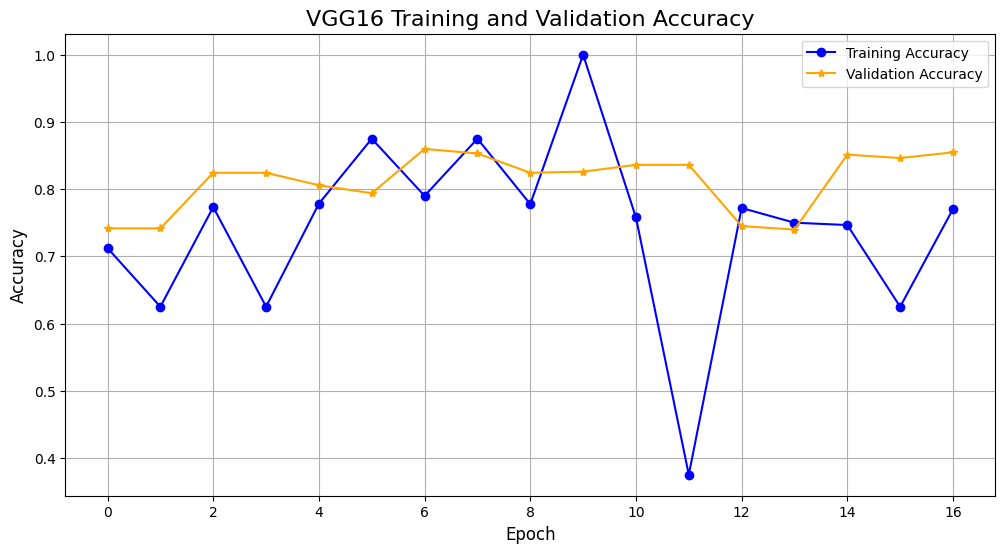

In [12]:
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.figure(figsize=(12, 6))
plt.plot(train_acc, label='Training Accuracy', color='blue', marker='o')
plt.plot(val_acc, label='Validation Accuracy', color='orange', marker='*')
plt.title('VGG16 Training and Validation Accuracy', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Accuracy', fontsize=12)
plt.legend(loc='best')
plt.grid(True)
plt.show()